In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [4]:
train_X = pd.read_csv("train_X.csv").set_index('mid')
train_X_normalized = pd.read_csv("train_X_normalized.csv").set_index('mid')
train_y = pd.read_csv('train_y.csv').set_index('mid')['radiant_win']

### (7 баллов) Обучение классификаторов на вещественных признаках

В данном разделе будет необходимо работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор гиперпараметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 4 алгоритма:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)

Значения остальных гиперпараметров оставляйте по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). В качестве схемы кросс-валидации используйте 5-Fold CV, которую можно задать с помощью класса [KFoldCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold).

![](https://i.stack.imgur.com/YWgro.gif)

**(1.5 балла) Задание 2.** Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Для получения значения качества на каждом фолде, среднего значение качества и другой полезной информации можно воспользоваться полем [*cv results_*](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

У какого алгоритма наибольшее среднее значение качества? Наибольший доверительный интервал?

Определим фунции, которые позволят удобно рисовать графики и искать максимальное значение гиперпараметра

In [47]:
def draw(results, param, title, limit=None):
    if limit is not None:
        results = results[results['mean_test_score'] > limit]
        
    plt.rcParams["figure.figsize"]=10,5
    
    mean = results['mean_test_score']
    std = results['std_test_score']
    xasix = list(results['param_'+ param])
    
    plt.grid()
    plt.fill_between(xasix, mean - std, mean + std, alpha=0.1, color="r")
    plt.plot(xasix, mean, 'o-', color="r",
                 label="Cross-validation score")
    plt.legend()
    plt.xlabel(param)
    plt.ylabel("Score")
    plt.show()
    
def print_max(results, param, limit = None):
    params = results['param_' + param]
    mean = results['mean_test_score']
    std = results['std_test_score']
        
    if limit is None:
        idx = np.argmax(mean)
        return f'{param}: {params[idx]}, score: {mean[idx]}, std: {std[idx]}'
    
    return results[results['mean_test_score'] > limit]

###  KNeighborsClassifier

С помощью нескольких запусков на общем кластере вычислим характеристики для разного количества соседей. Сначала будем двигаться с шагом 1000, далее уточнять с шагом 10 и найдем финальное значение с шагом 1

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
min_range = 1
max_range = 2
step = 1
n_neighbors = list(range(min_range, max_range, step))
neighbors = KNeighborsClassifier()
clf = GridSearchCV(neighbors, {'n_neighbors': n_neighbors}, cv=5, n_jobs=-1, scoring='roc_auc')
clf.fit(train_X, train_y)
results_knn = clf.cv_results_
;

''

Для наглядного тображения построим график скора от количества соседей по заранее подготовленным данным

In [86]:
results = pd.read_csv('knn.csv').set_index('param_n_neighbors').sort_index().reset_index()

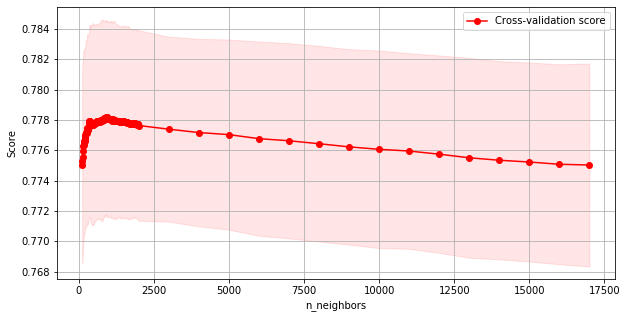

In [76]:
draw(results, 'n_neighbors', 'KNN', 0.775)

Наилучший результат достигается на **928** соседях

In [87]:
print_max(results, 'n_neighbors')

'n_neighbors: 928, score: 0.7781616542343285, std: 0.006406089030173061'

Для дальнейших расчетов будем использовать близкое меньшее количество соседей **740**, но с небольшой разницей по скору

In [93]:
print_max(results, 'n_neighbors', 0.778)

param_n_neighbors  mean_test_score  std_test_score
65                 740         0.778005        0.006520
72                 810         0.778015        0.006542
73                 820         0.778058        0.006524
74                 830         0.778002        0.006465
75                 840         0.778030        0.006451
..                 ...              ...             ...
187               1150         0.778018        0.006493
188               1160         0.778019        0.006514
189               1170         0.778002        0.006500
190               1180         0.778016        0.006495
191               1190         0.778006        0.006477

[117 rows x 3 columns]

## DecisionTree

Расчитаем эффективность нашего алгоритма путем перебора глубины и построим график

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

max_depth = list(range(1, 20))
dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, {'max_depth': max_depth}, cv=5, n_jobs=-1, scoring='roc_auc')
clf.fit(train_X, train_y)
results_decision_tree = clf.cv_results_
;

''

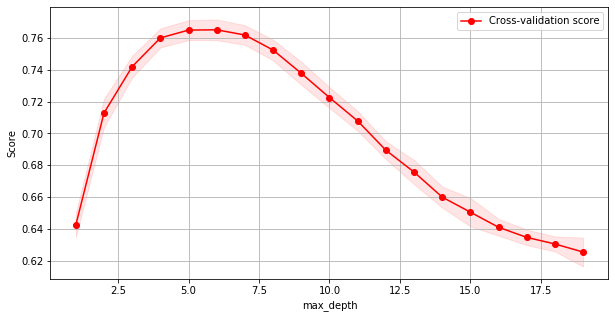

In [54]:
draw(results_decision_tree, 'max_depth', 'DecisionTree')

Лучшее значение параметра достигается при глубине дерева **6: 0.7650241305795809**

In [55]:
print_max(results_decision_tree, 'max_depth')

'max_depth: 6, score: 0.7650241305795809, std: 0.0065013579144704145'

## SGD Linear Classifier

Расчитаем эффективность для разных функций потерь, которые применимы к классификатору, остальные дают совсем низкий результат

In [66]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
sgd = SGDClassifier()
clf = GridSearchCV(sgd, {'loss': loss}, cv=5, n_jobs=-1, scoring='roc_auc')
clf.fit(train_X, train_y)
results_sgd = clf.cv_results_
;

''

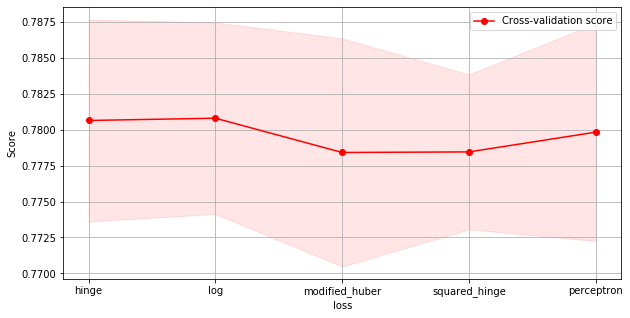

In [67]:
draw(results_sgd, 'loss', 'SGD Linear Classifier')

Лучшее значение параметра достигается при функции потерь `log` **0.780795529898613**:

In [68]:
print_max(results_sgd, 'loss')

'loss: log, score: 0.780795529898613, std: 0.0066623699509413235'

**(0.5 балл) Задание 3.** Теперь подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев. Подберите количество деревьев, начиная с которого качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев: обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества деревьев разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте найденное количество деревьев.

Применить класс *GridSearchCV* в данном задании затруднительно, поэтому предлагается самостоятельно написать цикл по числу деревьев.

Будем действовать похожим с knn способом. Прогоним все вычисления на кластере и запишем в файл

Создадим 5 фолдов, для каждого запишем трейновые и тестовые данные, а так же сохраним обученые модели.
Запомним средний скор по фолдам

In [59]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

n_estimators = 5
columns = ['param_n_estimators', 'mean_test_score', 'std_test_score']
kf = KFold(n_splits=5)

X_train = []
X_test = []
y_train = []
y_test = []
rfc_bulk = []
score = []

for train_index, test_index in kf.split(train_X):
    X_train.append(train_X.iloc[train_index, :])
    X_test.append(train_X.iloc[test_index, :])
    y_train.append(train_y.iloc[train_index])
    y_test.append(list(train_y.iloc[test_index]))

for i in range(5):
    current_model = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    rfc_bulk.append(current_model)
    
    current_model.fit(X_train[i], y_train[i])
    proba = current_model.predict_proba(X_test[i])[:, 1]
    current_score = roc_auc_score(y_test[i], proba)
    score.append(current_score)
    
mean_test_score = np.mean(score)
std = np.std(score)

Начнем собирать средний скор в зависимости от количества деревьев

In [64]:
estimators_score = pd.DataFrame([[n_estimators, mean_test_score, std]], columns=columns).set_index('param_n_estimators')

Будем отрезать последнее дерево и считать средний сокр по оставшимся

In [69]:
for j in range(n_estimators - 1, 1, -1):
    print(j)
    newtree_score = []
    for i in range(5):
        current_model = rfc_bulk[i]
        current_model.estimators_.pop()

        proba = current_model.predict_proba(X_test[i])[:, 1]
        current_score = roc_auc_score(y_test[i], proba)
        newtree_score.append(current_score)

    mean_test_score = np.mean(newtree_score)
    std = np.std(newtree_score)
    estimators_score = estimators_score.append(pd.DataFrame([[j, mean_test_score, std]], columns=columns).set_index('param_n_estimators'))
    

In [95]:
results = pd.read_csv("rf.csv")

Для наглядного тображения построим график скора от количества деревьев по заранее подготовленным данным

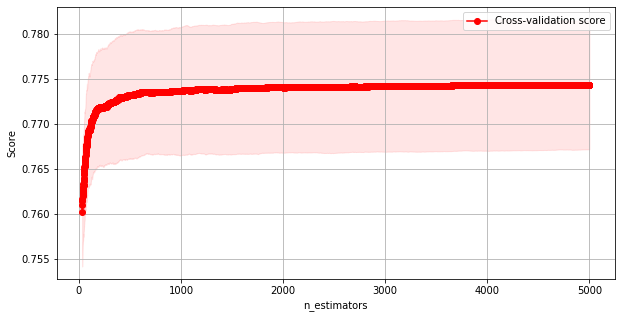

In [97]:
draw(results, 'n_estimators', 'Random Forest', 0.76)

Так как на случайных деревьях переобучения не возникает, то лучший скор мы получаем практически при максимальном количестве деревьев **4501**

In [98]:
print_max(results, 'n_estimators')

'n_estimators: 4501, score: 0.7743684689543656, std: 0.007230779189479635'

Для дальнейшних вычислений будем использовать существенно меньшее количество **1546** при этом не сильно ухудшая скор модели

In [99]:
print_max(results, 'n_estimators', 0.774)

param_n_estimators  mean_test_score  std_test_score
1544                1546         0.774001        0.007280
1545                1547         0.774012        0.007278
1546                1548         0.774013        0.007283
1547                1549         0.774010        0.007286
1548                1550         0.774009        0.007283
...                  ...              ...             ...
4994                4996         0.774352        0.007138
4995                4997         0.774353        0.007136
4996                4998         0.774353        0.007135
4997                4999         0.774353        0.007135
4998                5000         0.774356        0.007137

[3417 rows x 3 columns]

### Выводы

Наилучшее предсказание мы получили для sgd классификатора с логистической функции потерь: **0.780795529898613**

Размер доверительного интервала равен двум стандартным отклонениям, поэтому чем выше std_test_score, тем больше доверительный интервал.
В целом, стандартное отклонение очень низкое для всех моделей, но самое большое получилось для случайных деревьев: **0.007230779189479635**